# PD 5 Metody grupowania
Treść zadania

Zadanie polega na przetestowaniu minimum 2 metod klasteryzujących. Następnie należy wybrać optymalną liczbę klastrów. W każdej metodzie należy wykorzystać inny sposób wybierania optymalnej liczby klastrów.

Raport powinien zawierać:

    graficzne przedstawienie przypisania do klastrów dla 2 wybranych metod klasteryzujących
    Argumentację dlaczego taka liczba klastrów a nie inna, potwierdzona wykresem, obrazkiem, metryką, itp.

Proponowane metody:

    k-średnich, k-medoidów, ...
    hierarchiczne (aglomeracyjna, deglomeracyjna)


In [24]:
# Wczytujemy pakiety
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig_size = 12, 8

In [23]:
# Wczytujemy dane
df=pd.read_csv("C:\\Users\\huber\\Dropbox\\PW\\2 SEMESTR\\Wstep do uczenia maszynowego\\clustering.txt")
df.head()

,X,Y
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


<AxesSubplot:xlabel='X', ylabel='Y'>

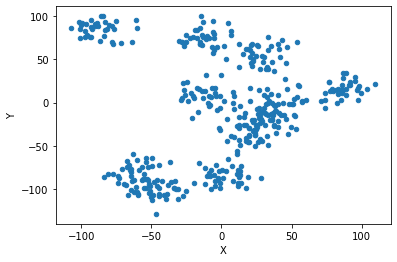

In [12]:
# Patrzymy na dane, bo są w 2 wymiarach
df.plot.scatter(0,1)

Dane wczytały się poprawnie. Teraz przejdziemy do przetestwania metod klasteryzujących. 
Na pierwszy rzut oka możemy wyróżnić intuicyjnie albo 8 klastrów, 6 klastrów albo 3 grupy. Zobaczymy, które z tych okażą się wybrane także przez algorytmy.
## Metoda k średnich

W głównej mierze będę korzystał z funkcji już podanych na zajęciach. Rozpocznę od narysowania wykresu i metody łokcia, aby zobaczyć ile klastrów sugeruje aby dobrać ostatecznie. WCSS mierzy sumę odległosci obiektów w ramach grupy od ich centroidy.

In [36]:
from sklearn.cluster import KMeans
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores
X=df.to_numpy()

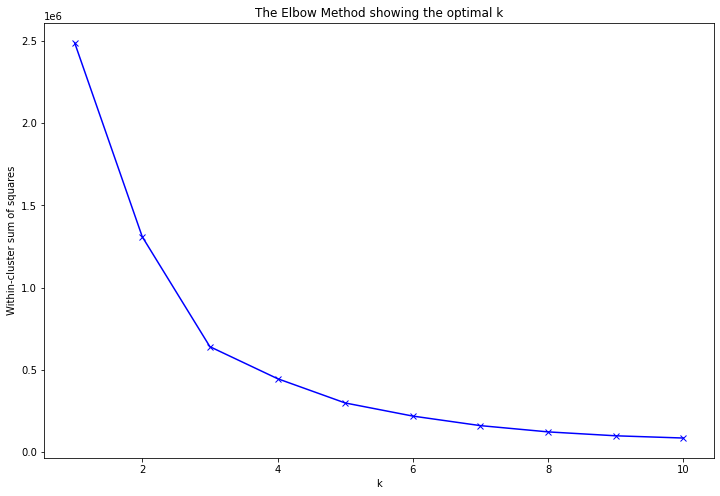

In [38]:
wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
f = plt.figure(figsize=fig_size)
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Wynik wychodzi niestety nie do końca konkluzywny, nie widać wyraźnego załamania. Może warto wybrać trzy klastry? To dla tej wielkości występuje największe załamanie. Posłużymy się teraz miarą Silhouette.

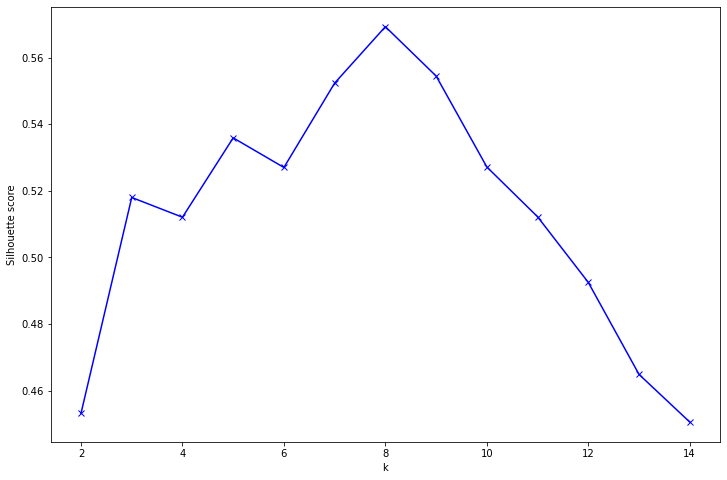

In [40]:
def count_clustering_scores(X, cluster_num, model_class, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_class(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 15) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
f = plt.figure(figsize=fig_size)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Miara Silhouette premiuje okrągłe grupy. Im wyższa wartość dla danej obserwacji tym jest ona bliższa centrum. Miara Silhouette jest średnią ze wszystkich obserwacji po wszystkich klastrach. Metoda sugeruje wybór 8 klastrów.

Posłużmy się innymi metrykami.

In [46]:
from scipy.spatial import distance
import numpy as np


def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

print("Dla 3 klastrów:")
print(f'Minimal distance between clusters = {count_clustering_scores(X, 4, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X, 3, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X, 3, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X, 3, KMeans, mean_dist_to_center):.2f}.')

Dla 3 klastrów:
Minimal distance between clusters = 3.26.
Average distance between points in the same class = 47.83.
Standard deviation of distance between points in the same class = 5.771.
Average distance to cluster center = 36.43.


In [48]:
print("Dla 6 klastrów:")
print(f'Minimal distance between clusters = {count_clustering_scores(X, 4, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X, 6, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X, 6, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X, 6, KMeans, mean_dist_to_center):.2f}.')

Dla 6 klastrów:
Minimal distance between clusters = 3.26.
Average distance between points in the same class = 25.92.
Standard deviation of distance between points in the same class = 6.640.
Average distance to cluster center = 18.70.


In [49]:
print("Dla 8 klastrów:")
print(f'Minimal distance between clusters = {count_clustering_scores(X, 4, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X, 8, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X, 8, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X, 8, KMeans, mean_dist_to_center):.2f}.')

Dla 8 klastrów:
Minimal distance between clusters = 3.26.
Average distance between points in the same class = 20.98.
Standard deviation of distance between points in the same class = 2.544.
Average distance to cluster center = 14.77.


Co ciekawe minimalna odległość między punktami różnych klastrów jest taka sama dla trzech przypadków. Średnia odległość między punktami jest najmniejsza dla 8 grup, co wydaje się dosyć intuicyjne. Odchylenie standrardowe odległości pomiędzy punktami dla 6 klas jest najwyższe, co trochę dyskredytuje ten podział.
Aby mieć pełen przegląd możemy wyrysować nasze miary z zajęć dla całej siatki podziałów.

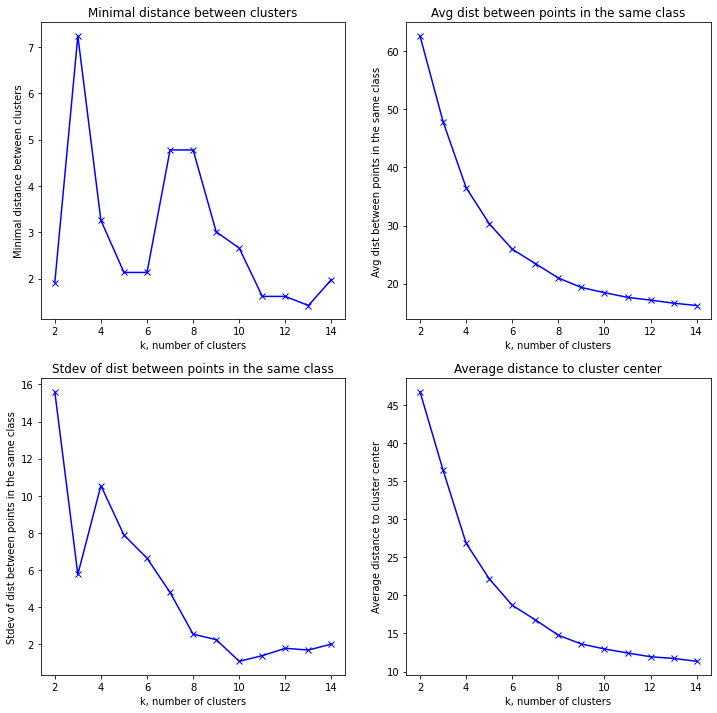

In [76]:
def make_plot(ax, cluster_num_seq, scoring, title):
    scores_vec = count_clustering_scores(np.array(df), cluster_num_seq, KMeans, scoring)
    ax.plot(cluster_num_seq, scores_vec, 'bx-')
    plt.setp(ax, xlabel="k, number of clusters", ylabel=title, title=title)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
clust_nums = range(2,15)
make_plot(ax1, clust_nums, min_interclust_dist, "Minimal distance between clusters")
make_plot(ax2, clust_nums, mean_inclust_dist, "Avg dist between points in the same class")
make_plot(ax3, clust_nums, std_dev_of_inclust_dist, "Stdev of dist between points in the same class")
make_plot(ax4, clust_nums, mean_dist_to_center, "Average distance to cluster center")

In [61]:
def plot_voronoi_diag(model, X, res=1000, margin=0.2):
    # source: https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb
    mins = X.min(axis=0) - margin
    maxs = X.max(axis=0) + margin
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], res),
                         np.linspace(mins[1], maxs[1], res))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')  
def plot_kmeans_centers(model):
    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=75, alpha=0.75)

def plot_data(X):
    plt.scatter(X[:,0], X[:,1], c='k', s=2)
def plot_kmeans_with_bounds(model, X):
    f = plt.figure(figsize=fig_size)
    plot_voronoi_diag(model, X)
    plot_data(X)
    plot_kmeans_centers(model)

Narysujemy teraz diagramy Voronoia dla podziału z 3, 6 i 8 grupami.

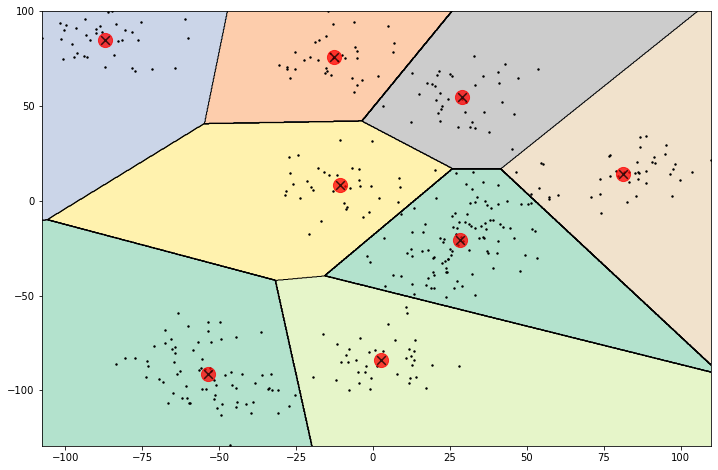

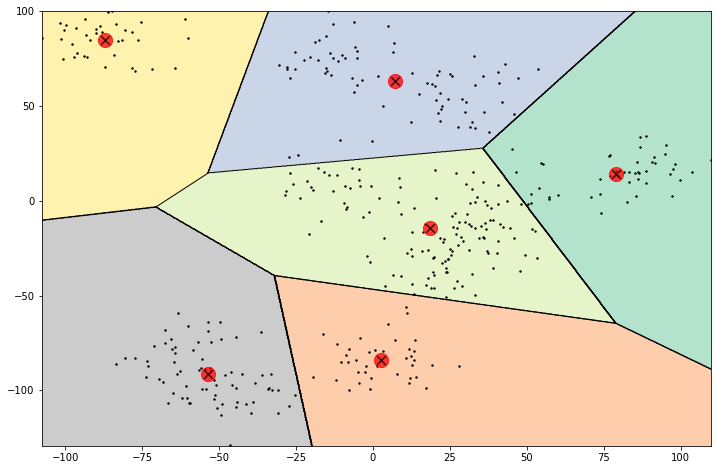

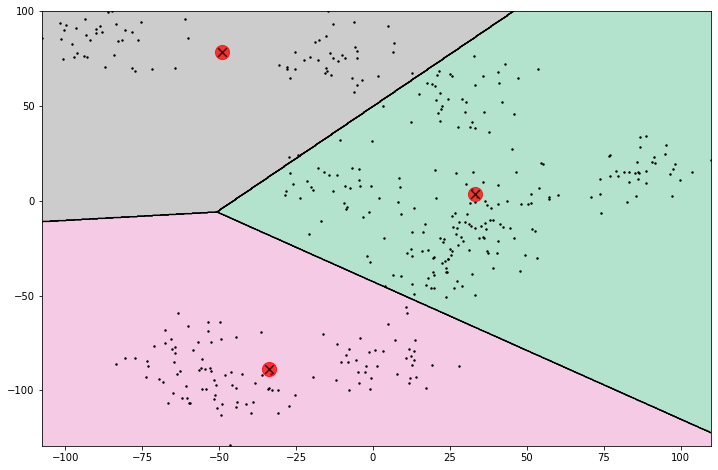

In [69]:
# Dla 3 dla 6 dla 8
kmeans_8 = KMeans(n_clusters=8, random_state=97, max_iter=1000) 
kmeans_8.fit(X)
kmeans_6 = KMeans(n_clusters=6, random_state=97, max_iter=1000) 
kmeans_6.fit(X)
kmeans_3 = KMeans(n_clusters=3, random_state=97, max_iter=1000) 
kmeans_3.fit(X)
#plt.subplot(2, 3, 1)
plot_kmeans_with_bounds(kmeans_8, X)
#plt.subplot(2, 3, 2)
plot_kmeans_with_bounds(kmeans_6, X)
#plt.subplot(2, 3, 3)
plot_kmeans_with_bounds(kmeans_3, X)

Biorąc pod uwagę wszystkie miary skłaniałbym się albo ku podziałowi na 8 albo na 3 grupy.

# Klasteryzacja hierarchiczna

W tym rozdziale wykonamy porównanie grupowania hierarchicznego aglomeracyjnego zwanego także po ang. Agglomerative.

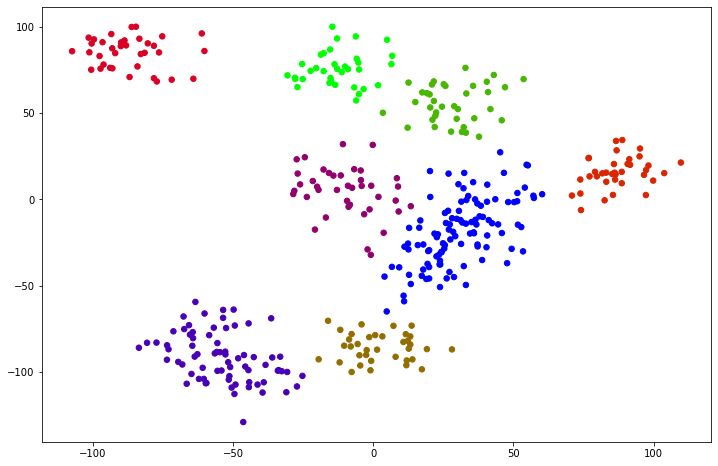

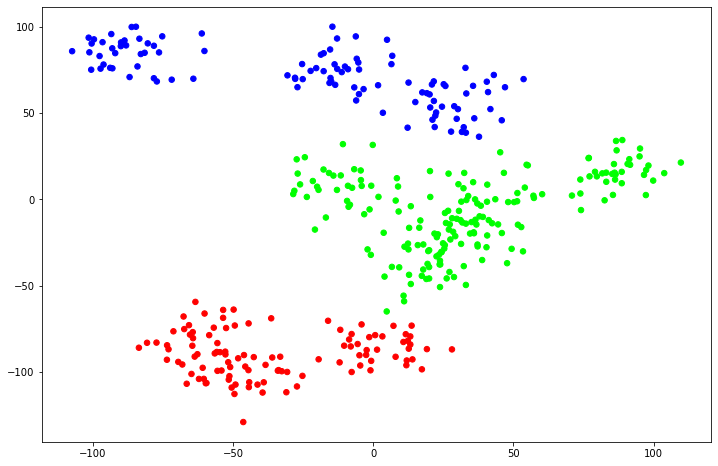

In [74]:
from sklearn.cluster import AgglomerativeClustering

model_8 = AgglomerativeClustering(n_clusters=8, linkage='ward')
y_pred = model_8.fit_predict(df)
f = plt.figure(figsize=fig_size)
plt.scatter(df.X,df.Y, c=y_pred, s=30, cmap='brg')

model_3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_pred = model_3.fit_predict(df)
f = plt.figure(figsize=fig_size)
plt.scatter(df.X,df.Y, c=y_pred, s=30, cmap='brg')
plt.show()

In [ ]:
Wykonamy te same wykresy różnych miar co dla k średnich.

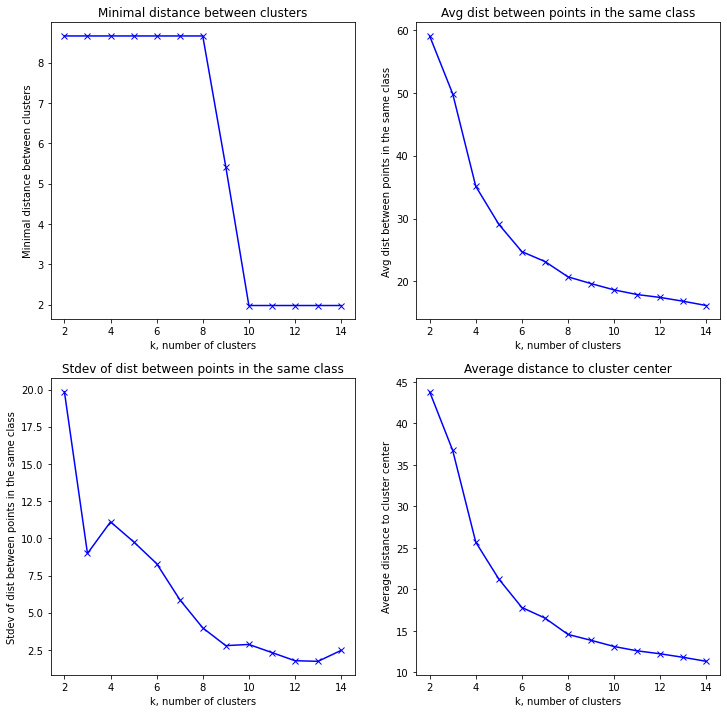

In [75]:
def make_plot(ax, cluster_num_seq, scoring, title):
    scores_vec = count_clustering_scores(np.array(df), cluster_num_seq, AgglomerativeClustering, scoring)
    ax.plot(cluster_num_seq, scores_vec, 'bx-')
    plt.setp(ax, xlabel="k, number of clusters", ylabel=title, title=title)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
clust_nums = range(2,15)
make_plot(ax1, clust_nums, min_interclust_dist, "Minimal distance between clusters")
make_plot(ax2, clust_nums, mean_inclust_dist, "Avg dist between points in the same class")
make_plot(ax3, clust_nums, std_dev_of_inclust_dist, "Stdev of dist between points in the same class")
make_plot(ax4, clust_nums, mean_dist_to_center, "Average distance to cluster center")

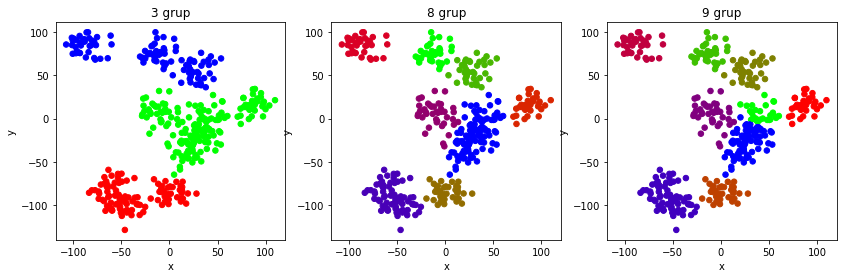

In [84]:
fig_size = 14,4
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=fig_size)

def make_plot_k(ax, clusters_num):
    y_pred = AgglomerativeClustering(n_clusters=clusters_num, linkage='ward').fit_predict(df)
    ax.scatter(df.X, df.Y, c=y_pred, s=30, cmap='brg')
    plt.setp(ax, xlabel="x", ylabel="y", title=f'{clusters_num} grup')
    
make_plot_k(ax1, 3)
make_plot_k(ax2, 8)
make_plot_k(ax3, 9)

Możemy jeszcze zbadać wpływ parametru linkage na wygląd grup.

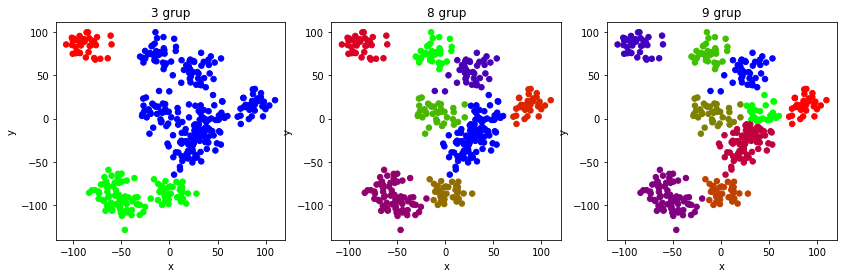

In [87]:
fig_size = 14,4
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=fig_size)

def make_plot_k(ax, clusters_num):
    y_pred = AgglomerativeClustering(n_clusters=clusters_num, linkage='average').fit_predict(df)
    ax.scatter(df.X, df.Y, c=y_pred, s=30, cmap='brg')
    plt.setp(ax, xlabel="x", ylabel="y", title=f'{clusters_num} grup')
    
make_plot_k(ax1, 3)
make_plot_k(ax2, 8)
make_plot_k(ax3, 9)

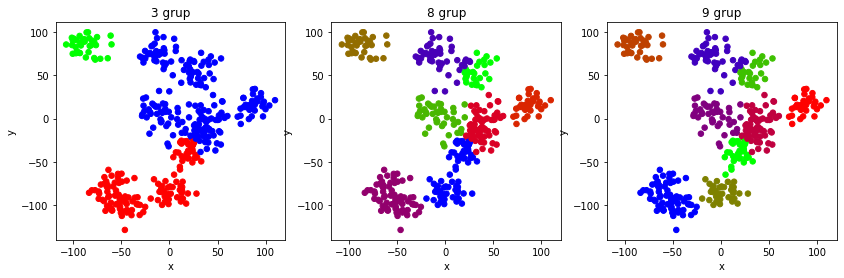

In [85]:
fig_size = 14,4
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=fig_size)

def make_plot_k(ax, clusters_num):
    y_pred = AgglomerativeClustering(n_clusters=clusters_num, linkage='complete').fit_predict(df)
    ax.scatter(df.X, df.Y, c=y_pred, s=30, cmap='brg')
    plt.setp(ax, xlabel="x", ylabel="y", title=f'{clusters_num} grup')
    
make_plot_k(ax1, 3)
make_plot_k(ax2, 8)
make_plot_k(ax3, 9)

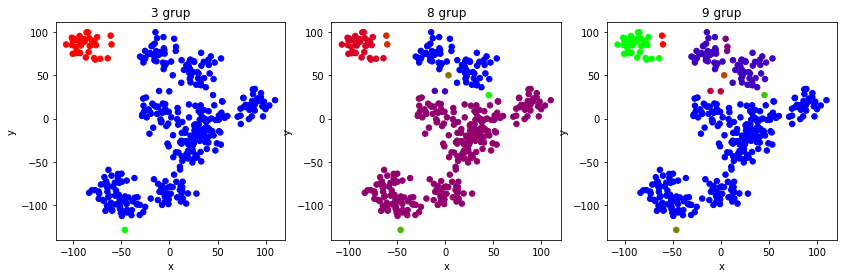

In [86]:
fig_size = 14,4
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=fig_size)

def make_plot_k(ax, clusters_num):
    y_pred = AgglomerativeClustering(n_clusters=clusters_num, linkage='single').fit_predict(df)
    ax.scatter(df.X, df.Y, c=y_pred, s=30, cmap='brg')
    plt.setp(ax, xlabel="x", ylabel="y", title=f'{clusters_num} grup')
    
make_plot_k(ax1, 3)
make_plot_k(ax2, 8)
make_plot_k(ax3, 9)

Połącenie **single** daje dosyć dziwne wyniki. Podobnie wyróżnia się połączenie **complete**. Połączenia **ward** i **average** dają wyniki zblizone. W tym przypadku pownownie wybrałbym albo 3 albo 8 grup patrząc po metrykach i sensowności wyglądu klastrów na rysunkach